# Import the library

In [1]:
import torch
from transformers import CLIPImageProcessor, CLIPVisionModel
from huggingface_hub import hf_hub_download, model_info

import sys, os
sys.path.append(os.path.abspath("src"))
import diffusers_custom

# inject your custom ReferenceNet modules into diffusers namespace
import diffusers_custom.models.referencenet as referencenet_models
import diffusers_custom.pipelines.referencenet as referencenet_pipelines

diffusers_custom.models.referencenet = referencenet_models
diffusers_custom.pipelines.referencenet = referencenet_pipelines

# Now imports will work unchanged:
from diffusers_custom.models.referencenet.referencenet_unet_2d_condition import ReferenceNetModel
from diffusers_custom.pipelines.referencenet.pipeline_referencenet import StableDiffusionReferenceNetPipeline


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Dell\Desktop\face_anon_simple\src\diffusers_custom\utils\outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\Dell\Desktop\face_anon_simple\src\diffusers_custom\utils\outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


# Create & load models

In [2]:
from diffusers import AutoencoderKL, DDPMScheduler

In [3]:
from tqdm.auto import tqdm
import os

In [ ]:
# Enable low memory mode
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

face_model_id = "hkung/face-anon-simple"
clip_model_id = "openai/clip-vit-large-patch14"
sd_model_id = "stabilityai/stable-diffusion-2-1"

print("=" * 60)
print("Loading Face Anonymization Model Components (Low Memory Mode)")
print("=" * 60)

# Set torch to use less memory
torch.set_num_threads(2)  # Reduce CPU threads to save memory

print("\n[1/7] Loading UNet...")
unet = ReferenceNetModel.from_pretrained(
    face_model_id, 
    subfolder="unet", 
    use_safetensors=True,
    low_cpu_mem_usage=True,  # Load in chunks
    torch_dtype=torch.float16  # Use half precision to save memory
)

print("\n[2/7] Loading ReferenceNet...")
referencenet = ReferenceNetModel.from_pretrained(
    face_model_id, 
    subfolder="referencenet", 
    use_safetensors=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16
)

print("\n[3/7] Loading Conditioning ReferenceNet...")
conditioning_referencenet = ReferenceNetModel.from_pretrained(
    face_model_id, 
    subfolder="conditioning_referencenet", 
    use_safetensors=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16
)

print("\n[4/7] Loading VAE...")
vae = AutoencoderKL.from_pretrained(
    sd_model_id, 
    subfolder="vae", 
    use_safetensors=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16
)

print("\n[5/7] Loading Scheduler...")
scheduler = DDPMScheduler.from_pretrained(
    sd_model_id, 
    subfolder="scheduler"
)

print("\n[6/7] Loading CLIP Feature Extractor...")
feature_extractor = CLIPImageProcessor.from_pretrained(
    clip_model_id
)

print("\n[7/7] Loading CLIP Image Encoder...")
image_encoder = CLIPVisionModel.from_pretrained(
    clip_model_id,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16
)


pipe = StableDiffusionReferenceNetPipeline(
    unet=unet,
    referencenet=referencenet,
    conditioning_referencenet=conditioning_referencenet,
    vae=vae,
    feature_extractor=feature_extractor,
    image_encoder=image_encoder,
    scheduler=scheduler,
)

generator = torch.manual_seed(1)

print("\n✓ Pipeline ready!")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading Face Anonymization Model Components (Low Memory Mode)

[1/7] Loading UNet...


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\diffusers\models\lora.py:393: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.



[2/7] Loading ReferenceNet...


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.



[3/7] Loading Conditioning ReferenceNet...


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.



[4/7] Loading VAE...

[5/7] Loading Scheduler...

[6/7] Loading CLIP Feature Extractor...


`torch_dtype` is deprecated! Use `dtype` instead!



[7/7] Loading CLIP Image Encoder...

✓ Pipeline ready!


# Anonymize images with a single aligned face

Create an anonymized version of an image if the image contains a single face and that face has already been aligned similarly to those in the [FFHQ](https://github.com/NVlabs/ffhq-dataset) or [CelebA-HQ](https://github.com/tkarras/progressive_growing_of_gans) datasets.

In [5]:
from PIL import Image

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\diffusers\models\resnet.py:323: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
  deprecate("scale", "1.0.0", deprecation_message)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\diffusers\models\downsampling.py:135: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
  deprecate("scale", "1.0.0", deprecation_message)
c:\Users\Dell\AppData\Local\Programs\Python\Python31

Done! Saved to quick_test.jpg


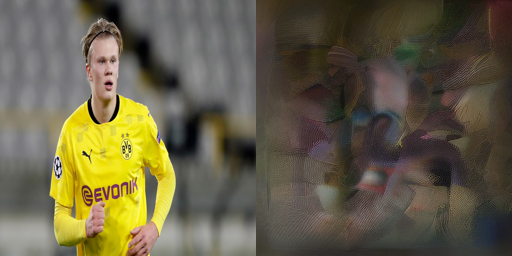

In [6]:
# Enable all speed optimizations
pipe.enable_attention_slicing(1)
if hasattr(pipe, 'enable_vae_slicing'):
    pipe.enable_vae_slicing()

img_path = "data/erling.jpg"
original_image = Image.open(img_path).resize((256, 256))  # Smaller!

# Absolute minimum settings
anon_image = pipe(
    source_image=original_image,
    conditioning_image=original_image,
    num_inference_steps=5,  # FIVE steps - bare minimum
    guidance_scale=3.0,
    generator=generator,
    anonymization_degree=1.25,
    width=256,
    height=256,
).images[0]

# Show result
w, h = original_image.size
comparison = Image.new('RGB', (w * 2, h))
comparison.paste(original_image, (0, 0))
comparison.paste(anon_image, (w, 0))

comparison.save("quick_test.jpg")
print("Done! Saved to quick_test.jpg")
comparison


# Anonymize images with one or multiple unaligned faces
Create an anonymized version of an image if it contains one or more unaligned faces.

100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


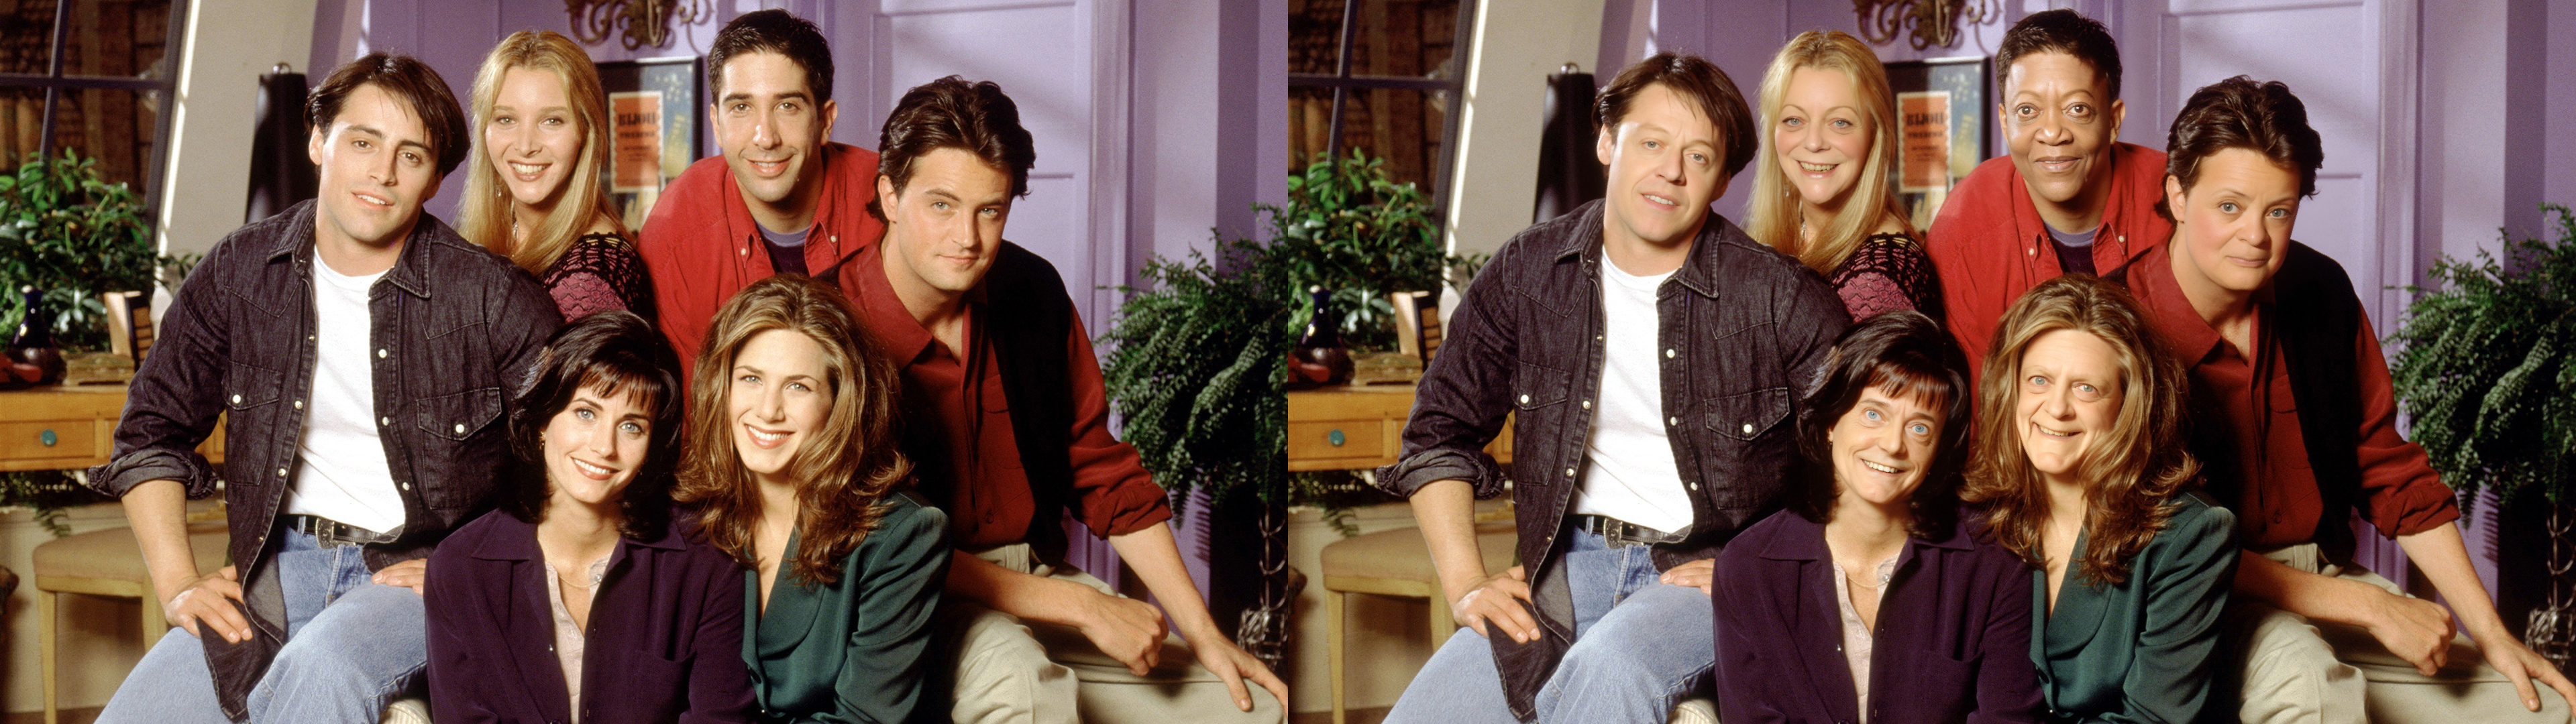

In [ ]:
import face_alignment
from utils.anonymize_faces_in_image import anonymize_faces_in_image

# get an input image for anonymization
img_path = "data/erling.jpg"
original_image = Image.open(img_path).resize((256, 256))  # Smaller!

# SFD (likely best results, but slower)
fa = face_alignment.FaceAlignment(
    face_alignment.LandmarksType.TWO_D, face_detector="sfd"
)

# generate an image that anonymizes faces
anon_image = anonymize_faces_in_image(
    image=original_image,
    face_alignment=fa,
    pipe=pipe,
    generator=generator,
    face_image_size=512,
    num_inference_steps=25,
    guidance_scale=4.0,
    anonymization_degree=1.25,
)


w, h = original_image.size
comparison = Image.new('RGB', (w * 2, h))
comparison.paste(original_image, (0, 0))
comparison.paste(anon_image, (w, 0))

comparison.save("quick_test_1.jpg")
print("Done! Saved to quick_test_1.jpg")
comparison

# Swap faces between two images

100%|██████████| 200/200 [01:13<00:00,  2.71it/s]


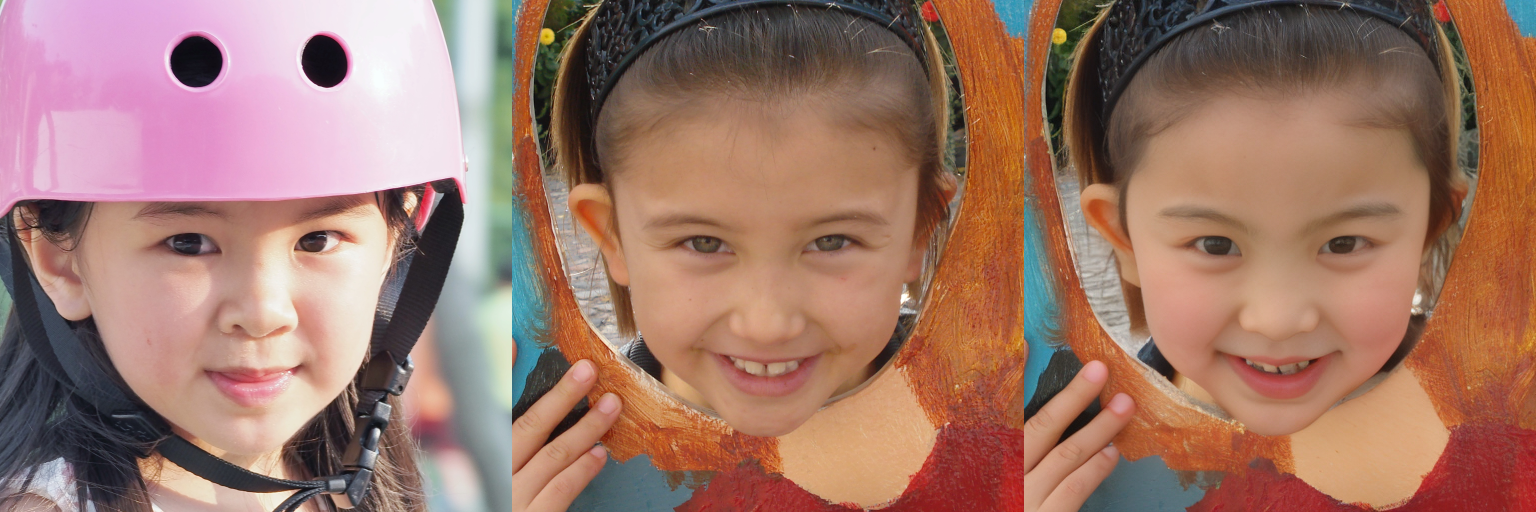

In [ ]:
# get source and conditioning (driving) images for face swap

source_image_path = "data/erling.jpg"
source_image = Image.open(source_image_path).resize((256, 256))  # Smaller!

conditioning_image_path = "data/nelli.jpg"
conditioning_image = Image.open(conditioning_image_path).resize((256, 256)) 

# generate an image that swaps faces
swap_image = pipe(
    source_image=source_image,
    conditioning_image=conditioning_image,
    num_inference_steps=200,
    guidance_scale=4.0,
    generator=generator,
    anonymization_degree=0.0,
    width=512,
    height=512,
).images[0]

w, h = original_image.size
comparison = Image.new('RGB', (w * 2, h))
comparison.paste(source_image, (0, 0))
comparison.paste(swap_image, (w, 0))

comparison.save("quick_test_2.jpg")
print("Done! Saved to quick_test_2.jpg")
comparison

# Anonymize Directory

In [ ]:
from pathlib import Path

# Directories
data_dir = "val2017_subset"
processed_dir = "val2017_subset_GANs_2"

# Create output directory if it doesn't exist
os.makedirs(processed_dir, exist_ok=True)

# Get all image files
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
image_files = [f for f in Path(data_dir).iterdir() 
               if f.suffix.lower() in image_extensions]

print(f"Found {len(image_files)} images to process")

# Process each image
for img_path in tqdm(image_files, desc="Anonymizing faces"):
    try:
        # Load and resize image
        original_image = Image.open(img_path).resize((256, 256))
        
        # Generate anonymized image
        anon_image = pipe(
            source_image=original_image,
            conditioning_image=original_image,
            num_inference_steps=5,
            guidance_scale=3.0,
            generator=torch.manual_seed(1),  # Reset seed each time for consistency
            anonymization_degree=1.25,
            width=256,
            height=256,
        ).images[0]
        
        # Save with same filename
        output_path = Path(processed_dir) / img_path.name
        anon_image.save(output_path)
        
    except Exception as e:
        print(f"\nError processing {img_path.name}: {e}")
        continue

print(f"\nDone! Processed images saved to {processed_dir}")